# Dependencies

In [4]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Torch version: 2.1.0.dev20230718
Using device: cpu


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [5]:
def plot_predictions(
    axis,
    fig,
    train_data,
    train_labels, 
    test_data, 
    test_labels,
    predictions):
  
    # plt.figure(figsize = (10, 7))
    
    axis.scatter(train_data, train_labels, c = "b", s = 1, label = "training data")

    axis.scatter(test_data, test_labels, c = "g", s = 20, label = "testing data")

    if predictions is not None:
        axis.scatter(test_data, predictions, c = "r", s = 10, label = "predictions")

    axis.legend(prop = {"size": 14})

def plot_loss(
    axis,
    fig,
    epoch_count,
    loss_values,
    test_loss_values
  ):


  loss_values = np.array(torch.tensor(loss_values).cpu().numpy())
  test_loss_values = np.array(torch.tensor(test_loss_values).cpu().numpy())

  # plt.figure(figsize = (10, 7))

  axis.plot(epoch_count, loss_values, label = "train loss")
  axis.plot(epoch_count, test_loss_values, label = "test loss")
  # axis.title('training and test loss curves')
  fig.suptitle('training and test loss curves')
  axis.set_xlabel('epochs')
  axis.set_ylabel('loss')
  axis.legend()


class LinearRegressionModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(
        torch.randn(
            1, 
            requires_grad = True, 
            dtype = torch.float))
    self.bias = nn.Parameter(
        torch.randn(
            1, 
            requires_grad = True, 
            dtype = torch.float))
    

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

class LinearRegressionModelWLayer(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features = 1,out_features = 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)



# Get Fake Data

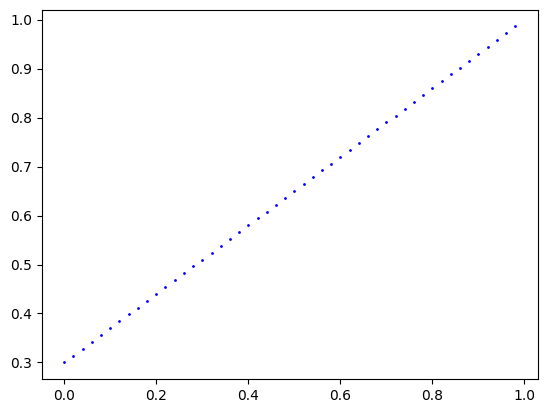

In [44]:
weight = 0.7
bias = 0.3

# range
start = 0
end = 1
step = 0.02

# create features and labels
X = torch.arange(start, end, step).unsqueeze(dim = 1) # features
y = weight * X + bias # labels

plt.scatter(X, y, c = "b", s = 1, label = "fake data")


# Prepare

In [45]:
epochs = 1000

learning_rate = 0.001

epoch_count = []
loss_values = []
test_loss_values = []

# Run

In [59]:
# SPLIT DATA
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# INIT MODEL
model_1 = LinearRegressionModelWLayer()

# MOVE MODEL AND DATA TO ONE DEVICE
model_1.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# INIT LOSS FUNCTION
loss_fn = nn.L1Loss()

# INIT OPTIMIZER
optimizer = torch.optim.SGD(lr = learning_rate, params = model_1.parameters())

In [61]:
X_train.shape

torch.Size([19519, 1])

In [47]:
start_epoch = 0 if len(epoch_count) == 0 else epoch_count[-1]

for epoch in tqdm(range(start_epoch, start_epoch + epochs)):

  # TRAINING MODE ON
  model_1.train()

  # CALC PREDICTIONS
  y_pred = model_1(X_train)

  # CALC LOSS
  loss = loss_fn(y_pred, y_train)

  # SET OPTIMIZER TO ZERO
  optimizer.zero_grad()

  # BACK PROPAGATION
  loss.backward() 

  # UPDATE PARAMETERS
  optimizer.step()

  # EVAL MODE ON
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)  
    test_loss = loss_fn(test_pred, y_test)
    
  # VISULIZE
  epoch_count.append(epoch)
  loss_values.append(loss)
  test_loss_values.append(test_loss)

  # LOG
  if epoch % int(epochs / 10) == 0:
      print(f"Epoch {epoch} | Loss {loss:.2f} | Test Loss {test_loss:.2f}")


 14%|█▍        | 144/1000 [00:00<00:00, 1435.63it/s]

Epoch 0 | Loss 0.53 | Test Loss 0.63
Epoch 100 | Loss 0.41 | Test Loss 0.50
Epoch 200 | Loss 0.30 | Test Loss 0.36


 68%|██████▊   | 684/1000 [00:00<00:00, 1712.06it/s]

Epoch 300 | Loss 0.18 | Test Loss 0.23
Epoch 400 | Loss 0.07 | Test Loss 0.09
Epoch 500 | Loss 0.01 | Test Loss 0.01
Epoch 600 | Loss 0.00 | Test Loss 0.01


100%|██████████| 1000/1000 [00:00<00:00, 1592.14it/s]

Epoch 700 | Loss 0.00 | Test Loss 0.00
Epoch 800 | Loss 0.00 | Test Loss 0.00
Epoch 900 | Loss 0.00 | Test Loss 0.00


# Visualize

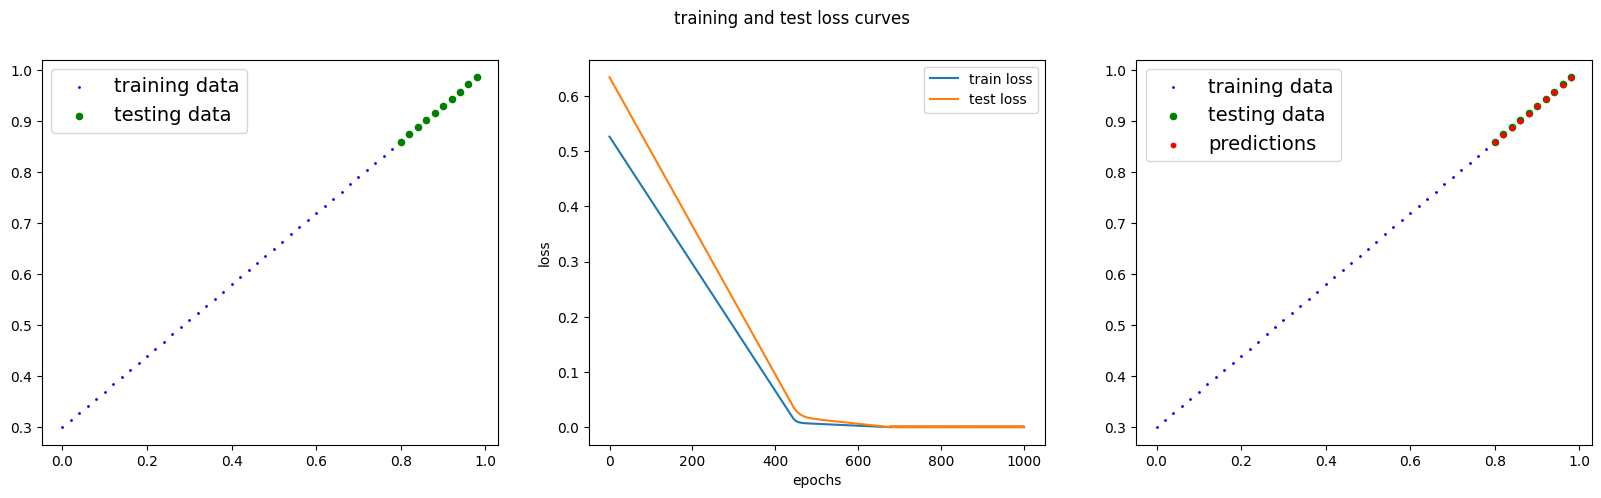

In [53]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

plot_predictions(
  axis = axis[0],
  fig = fig,
  train_data = X_train.cpu(),
  train_labels = y_train.cpu(),
  test_data = X_test.cpu(),
  test_labels = y_test.cpu(),
  predictions = None
)

plot_loss(
    axis = axis[1],
    fig = fig,
    epoch_count = epoch_count,
    loss_values = loss_values,
    test_loss_values = test_loss_values
)

model_1.eval() 

with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(
  axis = axis[2],
  fig = fig,
  train_data = X_train.cpu(),
  train_labels = y_train.cpu(),
  test_data = X_test.cpu(),
  test_labels = y_test.cpu(),
  predictions = y_preds.cpu()
)

# Save/Load

In [111]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# fake data we want to find


torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)
model_1_loaded = LinearRegressionModelWLayer()
model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_1_loaded.to(device)
model_1_loaded.state_dict() == model_1.state_dict()

model_1_loaded.eval()
with torch.inference_mode():
    model_1_loaded_preds = model_1_loaded(X_test)

y_preds == model_1_loaded_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])